In [1]:
import torch
from torchvision import datasets, transforms
import os

'''
-------------------对数据进行载入-------------------------
'''
data_dir = "D:\\datasets\\HRSC"
data_transform = {x: transforms.Compose([transforms.Resize([1000, 1000]),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))])
                  for x in ["Sea", "Land"]}  # 字典类型，key为train和valid，value是x: 后的内容
image_datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x), transform=data_transform[x])
                  for x in ["Sea", "Land"]}
print(image_datasets["Sea"].__init__)
dataloader = {x: torch.utils.data.DataLoader(dataset=image_datasets[x], batch_size=16, shuffle=True)
              for x in ["Sea", "Land"]}

X_example, y_example = next(iter(dataloader["Sea"]))
print("X_example个数", len(X_example))
print(type(X_example))
print("y_example个数", len(y_example))

index_classes = image_datasets["Sea"].class_to_idx    # 按顺序为这些类别定义索引为0,1...
print(index_classes)
example_classes = image_datasets["Sea"].classes   # 根据分的文件夹的名字来确定的类别
print(example_classes)
#print(image_datasets["Sea"].imgs)     # 返回从所有文件夹中得到的图片的路径以及其类别


<bound method ImageFolder.__init__ of Dataset ImageFolder
    Number of datapoints: 218
    Root location: D:\datasets\HRSC\Sea
    StandardTransform
Transform: Compose(
               Resize(size=[1000, 1000], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )>
X_example个数 16
<class 'torch.Tensor'>
y_example个数 16
{'0': 0}
['0']


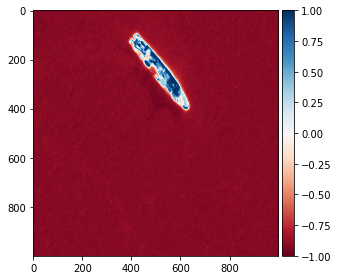

In [2]:
import numpy as np
from skimage import io
io.imshow(np.array(X_example[0,1,:,:]))

In [3]:
import collections
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import time
import pdb

class autoencoder(nn.Module):
    def __init__(self, in_channels=6, out_channels=6):
        super(autoencoder, self).__init__()
        
        self.encoder1 = nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=12,
                            kernel_size=7,
                            stride=2,
                            padding=3,
                            bias=True)
        self.encoder2 = nn.Conv2d(
                            in_channels=12,
                            out_channels=8,
                            kernel_size=5,
                            stride=2,
                            padding=2,
                            bias=True)
        self.encoder3 = nn.Conv2d(
                            in_channels=8,
                            out_channels=3,
                            kernel_size=3,
                            stride=1,
                            padding=1,
                            bias=True)
        
        self.decoder1 = nn.ConvTranspose2d(
                            in_channels=3,
                            out_channels=8,
                            kernel_size=3,
                            stride=1,
                            padding=1,
                            bias=True)
        self.decoder2 = nn.ConvTranspose2d(
                            in_channels=8,
                            out_channels=12,
                            kernel_size=5,
                            stride=2,
                            padding=1,
                            bias=True)
        self.decoder3 = nn.ConvTranspose2d(
                            in_channels=12,
                            out_channels=in_channels,
                            kernel_size=7,
                            stride=2,
                            padding=3,
                            bias=True)
        
        
    def forward(self, x):
        input_shape = x.shape[-2:]
        
        enc1 = self.encoder1(x)
        enc2 = self.encoder2( enc1 )
        bottleneck = self.encoder3( enc2 )
        
        dec1 = self.decoder1(bottleneck)
        dec2 = self.decoder2(dec1)
        dec3 = self.decoder3(dec2)
        
        y = F.interpolate(dec3, size=input_shape, mode="bilinear", align_corners=False)
        return y

In [4]:
model = autoencoder(in_channels=3, out_channels=3)

In [5]:
model.load_state_dict(torch.load('SAMMIE_Sea_model_last.pth')) #加载模型参数

<All keys matched successfully>

In [6]:
y = model(X_example)
y.shape

torch.pow(X_example - y,2).sum()
torch.tensor(X_example.shape).cumprod(dim=0)[-1]

tensor(48000000)

In [7]:
# 损失和优化函数
class SquaredErrorLoss(nn.Module):
    def __init__(self):
        super(SquaredErrorLoss, self).__init__()
        
    def forward(self, X, Y):
        input_shape = torch.tensor(X.size())
        Error = torch.pow(X - Y, 2).sum() / input_shape.cumprod(dim=0)[-1]
        return Error
    

loss_f = SquaredErrorLoss()  #torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [8]:
loss_f(X_example, y)

tensor(0.0096, grad_fn=<DivBackward0>)

In [9]:
pred = torch.mean(pow(X_example - y,2), dim=[1])
pred.mean(dim=[1,2])

tensor([0.0061, 0.0062, 0.0056, 0.0085, 0.0071, 0.0083, 0.0195, 0.0058, 0.0068,
        0.0067, 0.0126, 0.0059, 0.0064, 0.0253, 0.0062, 0.0159],
       grad_fn=<MeanBackward1>)

In [16]:
# 配置GPU，开始进行训练
Use_gpu = torch.cuda.is_available()

if Use_gpu:
    print( torch.cuda.get_device_properties(device = 0) )
    model = model.cuda()
    
epoch_n = 2 # 200
time_open = time.time()
f = open('Loss_log.txt', 'a+')

for epoch in range(epoch_n):
    print("Epoch {}/{}".format(epoch, epoch_n - 1))
    print("-"*10)
    
    for phase in ["train"]: #, "valid"
        if phase == "train":
            print("Training...")
            model.train(True)
        else:
            # 把BatchNormalization和DropOut固定住，不会取平均，而是用训练好的值
            print("Valid...")
            model.train(False) 
            
        running_loss = 0.0
        running_corrects = 0.0
        
        for batch, data in enumerate(dataloader["Sea"], start = 1): #组合为一个索引序列
            X, y = data
            #X = X.permute(0,3,1,2).to(torch.float32)
            #y = y.to(torch.float32)
            if Use_gpu:
                X, y = Variable(X.cuda()), Variable(y.cuda())
            else:
                X, y = Variable(X), Variable(y)
            
            y_pred = model.forward(X)
            error_map = torch.pow(X - y_pred, 2)
            pred = torch.mean(error_map, dim=[1])
            
            # Squared Error Loss
            loss = loss_f(y_pred, X) 
            
            # 对参数梯度的归零
            optimizer.zero_grad()
            if phase == "train":
                # 计算反向传播梯度值 P167
                loss.backward() 
                # 对节点的参数进行梯度更新 P169
                optimizer.step()
                
            running_loss += float(loss.data)
            running_corrects += float(torch.sum(pred.mean(dim=[1,2])))
            
            if batch%10000 == 0 and phase == "train":
                print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}"
                      .format(batch, running_loss/batch, 100*running_corrects/batch/ len(pred)))
                print("Current time {:.2f} min".format((time.time() - time_open)/60))
            
        epoch_loss = running_loss*16/len(image_datasets["Sea"])
        epoch_acc = 100*running_corrects/len(image_datasets["Sea"])
        
        print("{} Loss:{:.6f}  Acc:{:.6f}%".format(phase, epoch_loss, epoch_acc))
        f.write("{} Loss:{:.6f}  Acc:{:.6f}%\n".format(phase, epoch_loss, epoch_acc))
        time_end = time.time() - time_open
        print("Finish time {:.2f} min".format(time_end/60))

f.close()
torch.save(model.state_dict(), 'SAMMIE_Sea_model_last.pth')

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1080', major=6, minor=1, total_memory=8192MB, multi_processor_count=20)
Epoch 0/1
----------
Training...
train Loss:0.009991  Acc:0.980237%
Finish time 0.25 min
Epoch 1/1
----------
Training...
train Loss:0.010101  Acc:0.977706%
Finish time 0.43 min


In [10]:
import matplotlib.pyplot as plt

img = np.array(pow((X-y_pred),2)[5,:,:,:].detach().cpu().mean(dim=0))
plt.imshow(img)
plt.imshow(X[0,:,:,:].detach().cpu().permute([1,2,0]))
plt.figure()
plt.imshow(img, cmap=plt.cm.jet)
plt.colorbar()

NameError: name 'X' is not defined

In [74]:
pow((X-y_pred),2)[5,:,:,:].detach().cpu().mean(dim=0)

tensor([[0.4279, 0.4249, 0.4266,  ..., 0.4186, 0.4693, 0.4734],
        [0.4018, 0.3815, 0.3694,  ..., 0.3695, 0.3172, 0.4613],
        [0.2990, 0.3710, 0.2757,  ..., 0.3479, 0.3473, 0.4175],
        ...,
        [0.3869, 0.4067, 0.2721,  ..., 0.3317, 0.2997, 0.3724],
        [0.4381, 0.3978, 0.3091,  ..., 0.3544, 0.3801, 0.3869],
        [0.5453, 0.5235, 0.3361,  ..., 0.4000, 0.3897, 0.4551]])

# test_novel

In [11]:
X_land, y_land = next(iter(dataloader["Land"]))
print("x_land个数", len(X_land))
print(type(X_example))
print("y_example个数", len(y_land))

index_classes = image_datasets["Land"].class_to_idx    # 按顺序为这些类别定义索引为0,1...
print(index_classes)
land_classes = image_datasets["Land"].classes   # 根据分的文件夹的名字来确定的类别
print(example_classes)

x_land个数 16
<class 'torch.Tensor'>
y_example个数 16
{'1': 0}
['0']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


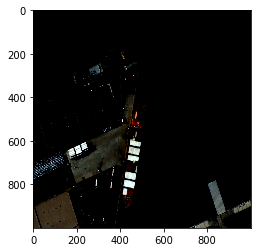

In [12]:
plt.imshow(X_land[3,:,:,:].permute([1,2,0]))

In [13]:
if next(model.parameters()).device.type == 'gpu':
    X_land = X_land.cuda()
y_land = model(X_land)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


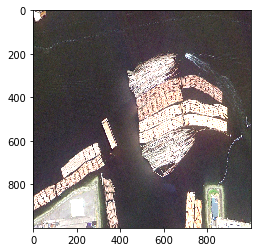

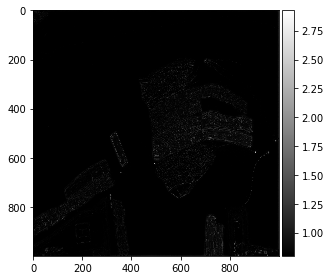

In [14]:
n = 0
img = X_land[n,:,:,:].detach().cpu().permute([1,2,0]) + 1
error_map = np.array(pow((X_land-y_land),2)[n,:,:,:].detach().cpu().permute([1,2,0])) #.mean(dim=0)

plt.imshow(img)
plt.figure()
io.imshow((error_map).mean(2), cmap='gray')
#plt.colorbar()


In [ ]:
plt.imsave("error_map.jpg", np.array(error_map)/2) #,cmap="gray"
plt.imsave("img.jpg", np.array( img)/2)

# 图像分割，陆地区域对比测试

In [20]:
import os
import cv2
data_dir = 'D:/Datasets/HRSC'
input_w,input_h = 256,256
image_set_index_file = os.path.join(data_dir, 'Segmentations.txt')

with open(image_set_index_file, 'r') as f:
    lines = f.readlines()
segm_lists = [line.strip() for line in lines]

In [21]:
# 读取标签文件
def load_annotation(image, labelFile):
    category = ['plane','baseball-diamond','bridge','ground-track-field',
            'small-vehicle','large-vehicle','ship','tennis-court','basketball-court',
            'storage-tank','soccer-ball-field','roundabout',
            'harbor','swimming-pool','helicopter']
    cat_ids = {cat:i for i,cat in enumerate(category)}
    w = image.shape[1]
    h = image.shape[0]
    down_ratio_w = image.shape[1]/256 #args.input_w
    down_ratio_h = image.shape[0]/256 #args.input_h
    
    valid_pts = []
    valid_cat = []
    valid_dif = []
    valid_rect = []
    with open(labelFile, 'r') as f:
        for i, line in enumerate(f.readlines()):
            obj = line.split(' ')  # list object
            if len(obj)>8:
                x1 = min(max(float(obj[0]), 0), w - 1)
                y1 = min(max(float(obj[1]), 0), h - 1)
                x2 = min(max(float(obj[2]), 0), w - 1)
                y2 = min(max(float(obj[3]), 0), h - 1)
                x3 = min(max(float(obj[4]), 0), w - 1)
                y3 = min(max(float(obj[5]), 0), h - 1)
                x4 = min(max(float(obj[6]), 0), w - 1)
                y4 = min(max(float(obj[7]), 0), h - 1)
                # TODO: filter small instances
                xmin = max(min(x1, x2, x3, x4), 0)
                xmax = max(x1, x2, x3, x4)
                ymin = max(min(y1, y2, y3, y4), 0)
                ymax = max(y1, y2, y3, y4)
                rect = cv2.minAreaRect(np.array([[x1//down_ratio_w,y1//down_ratio_h], 
                                      [x2//down_ratio_w,y2//down_ratio_h], 
                                      [x3//down_ratio_w,y3//down_ratio_h], 
                                      [x4//down_ratio_w,y4//down_ratio_h]], dtype=np.int64))
                out_rects = [rect[0][0], rect[0][1], rect[1][0], rect[1][1], rect[2]]
                
                if ((xmax - xmin) > 10) and ((ymax - ymin) > 10):
                    valid_pts.append([[x1//down_ratio_w, y1//down_ratio_h],
                                      [x2//down_ratio_w, y2//down_ratio_h],
                                      [x3//down_ratio_w, y3//down_ratio_h],
                                      [x4//down_ratio_w, y4//down_ratio_h]])
                    valid_cat.append(cat_ids[obj[8]])
                    valid_dif.append(int(obj[9]))
                    valid_rect.append(out_rects)
                    #print(valid_pts)
    f.close()
    annotation = {}
    annotation['pts'] = np.asarray(valid_pts, np.float32)
    annotation['cat'] = np.asarray(valid_cat, np.int32)
    annotation['dif'] = np.asarray(valid_dif, np.int32)
    annotation['rect']= np.asarray(valid_rect, np.float32)
    return annotation

In [22]:
# 读取标签文件
def load_annotation(image, labelFile):
    category = ['plane','baseball-diamond','bridge','ground-track-field',
            'small-vehicle','large-vehicle','ship','tennis-court','basketball-court',
            'storage-tank','soccer-ball-field','roundabout',
            'harbor','swimming-pool','helicopter']
    cat_ids = {cat:i for i,cat in enumerate(category)}
    w = image.shape[1]
    h = image.shape[0]
    down_ratio_w = image.shape[1]/256 #args.input_w
    down_ratio_h = image.shape[0]/256 #args.input_h
    
    valid_pts = []
    valid_cat = []
    valid_dif = []
    valid_rect = []
    with open(labelFile, 'r') as f:
        for i, line in enumerate(f.readlines()):
            obj = line.split(' ')  # list object
            if len(obj)>8:
                x1 = min(max(float(obj[0]), 0), w - 1)
                y1 = min(max(float(obj[1]), 0), h - 1)
                x2 = min(max(float(obj[2]), 0), w - 1)
                y2 = min(max(float(obj[3]), 0), h - 1)
                x3 = min(max(float(obj[4]), 0), w - 1)
                y3 = min(max(float(obj[5]), 0), h - 1)
                x4 = min(max(float(obj[6]), 0), w - 1)
                y4 = min(max(float(obj[7]), 0), h - 1)
                # TODO: filter small instances
                xmin = max(min(x1, x2, x3, x4), 0)
                xmax = max(x1, x2, x3, x4)
                ymin = max(min(y1, y2, y3, y4), 0)
                ymax = max(y1, y2, y3, y4)
                rect = cv2.minAreaRect(np.array([[x1//down_ratio_w,y1//down_ratio_h], 
                                      [x2//down_ratio_w,y2//down_ratio_h], 
                                      [x3//down_ratio_w,y3//down_ratio_h], 
                                      [x4//down_ratio_w,y4//down_ratio_h]], dtype=np.int64))
                out_rects = [rect[0][0], rect[0][1], rect[1][0], rect[1][1], rect[2]]
                
                if ((xmax - xmin) > 10) and ((ymax - ymin) > 10):
                    valid_pts.append([[x1//down_ratio_w, y1//down_ratio_h],
                                      [x2//down_ratio_w, y2//down_ratio_h],
                                      [x3//down_ratio_w, y3//down_ratio_h],
                                      [x4//down_ratio_w, y4//down_ratio_h]])
                    valid_cat.append(cat_ids[obj[8]])
                    valid_dif.append(int(obj[9]))
                    valid_rect.append(out_rects)
                    #print(valid_pts)
    f.close()
    annotation = {}
    annotation['pts'] = np.asarray(valid_pts, np.float32)
    annotation['cat'] = np.asarray(valid_cat, np.int32)
    annotation['dif'] = np.asarray(valid_dif, np.int32)
    annotation['rect']= np.asarray(valid_rect, np.float32)
    return annotation

In [23]:
model.train(False) 

land_error = []
ship_error = []
sea_error  = []

for index in range(len(segm_lists)):
    filename = segm_lists[index]
    imgFile = os.path.join(data_dir,'images',filename +'.png')
    labelFile = os.path.join(data_dir,'labelTXT',filename+'.txt')
    segmFile = os.path.join(data_dir,'Segmentations',filename+'.png')
    
    image = cv2.imread(imgFile)
    segm  = cv2.imread(segmFile)
    annotation = load_annotation(image, labelFile)
    
    # 预处理image
    image = cv2.resize(image, [input_w,input_h ])
    image = np.asarray(np.clip(image, a_min=0., a_max=255.), np.float32)
    #image = self.image_distort(np.asarray(image, np.float32))
    image = np.asarray(np.clip(image, a_min=0., a_max=255.), np.float32)
    image = np.transpose(image / 255. - 0.5, (2, 0, 1))
    
    # 预处理 Segmentation，提取白色陆地区域
    segm = cv2.resize(segm, [input_w,input_h ])
    idx = np.where((segm[:,:,0]>250)*(segm[:,:,1]>250)*(segm[:,:,2]>250))
    segmLand = np.zeros(segm.shape)
    segmLand[idx] = (1,1,1)
    #plt.imshow((segmLand+0.5) * np.transpose(image+0.5, (1,2,0)) )
    
    # 预处理 Segmentation，提取黑色海洋区域
    segm = cv2.resize(segm, [input_w,input_h])
    idx = np.where((segm[:,:,0]<5)*(segm[:,:,1]<5)*(segm[:,:,2]<5))
    segmSea = np.zeros(segm.shape)
    segmSea[idx] = (1,1,1)
    
    # 正向传播
    device = next(model.parameters()).device
    X = torch.tensor(image,device=device).unsqueeze(0)
    segm = torch.tensor(segmLand, device=device)
    
    y_pred = model.forward(X) #['out']
    error_map = torch.pow(X - y_pred, 2)
    #pred = torch.mean(error_map, dim=[1])
    if ((index+1)/len(segm_lists)*100)%25 == 0:
        print("proceeding {}%, Error Map: {}".format(index*100//len(segm_lists),
                                                 error_map.mean()))
    
    boxList= []
    maskShip = np.zeros(np.transpose(image,[1,2,0]).shape)
    for pts in annotation['rect']:
        #print(pts)
        x,y,w,h, angle= pts[:5]
        Ew,Eh = (3, 1.5) #扩大宽和长，包含周围环境
        if w > h:
            w,h = w * Eh, h * Ew
        else:
            w,h = w * Ew, h * Eh
        # 获取最小外接矩形的4个顶点坐标
        box = cv2.boxPoints(((x,y),(w,h),angle)) 
        box = np.int0(box)
        boxList.append(box)
        mask = np.zeros(np.transpose(image,[1,2,0]).shape)
        cv2.fillPoly(mask, [box], (1,1,1))
        maskShip = maskShip + mask
    maskShip[maskShip>1] = 1
    
    target = error_map[0].permute([1,2,0]).cpu().detach().numpy() * maskShip
    ship_error.append( float(target.sum()/((target>0).sum())) )
    
    target = error_map[0].permute([1,2,0]).cpu().detach().numpy() * segmLand
    land_error.append( float(target.sum()/((target>0).sum())) )
    
    target = error_map[0].permute([1,2,0]).cpu().detach().numpy() * segmSea
    sea_error.append( float(target.sum()/((target>0).sum())) )
    
    """
    image = cv2.drawContours( np.transpose(image,[1,2,0])+0.5, boxList, -1, (0,255,0), 1)
    cv2.imshow('img',image * (segmLand + maskShip*0.5 + 0.1))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    """

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


proceeding 24%, Error Map: 0.0037981353234499693
proceeding 49%, Error Map: 0.011019847355782986
proceeding 74%, Error Map: 0.01565137505531311


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars


proceeding 99%, Error Map: 0.012129384092986584


In [24]:
import pandas as pd
count_error =  pd.DataFrame({'list':segm_lists,
                             'ship': np.array(ship_error), 
                             'land':np.array(land_error),
                             'sea':np.array(sea_error) })
count_error = count_error.sort_values(by="ship",axis=0,ascending=False,inplace=False)
count_error.head()

,list,ship,land,sea
303,100001381,0.053868,0.042592,0.017675
170,100001040,0.052520,0.051506,0.011266
150,100000989,0.045905,NaN,0.008987
407,100001591,0.044372,0.052446,0.117272
398,100001570,0.043078,0.055218,0.015289


In [25]:
count = count_error.dropna(axis=0) # 除去nan
print(len(count))
print( "land>ship ratio: {}".format(sum(count['land'] > count['ship']) / len(count)) )
print( "land/ship average: {}".format(np.mean(count['land'] / count['ship']) ))

402
land>ship ratio: 0.7512437810945274
land/ship average: 1.335454364652185


In [26]:
print("{}\n({})".format( count['ship'].mean(), count['ship'].std() ) )
print("{}\n({})".format( count['land'].mean(), count['land'].std() ) )
print("{}\n({})".format( count['sea'].mean(),  count['sea'].std()  ) )

0.020142915451600962
(0.007961607671569686)
0.026247770958406268
(0.014628023743842283)
0.008941955445329811
(0.007503030100387312)


In [27]:
from scipy import stats
 
rvs_1, rvs_2 = count['ship'], count['land']
levene = stats.levene(rvs_1, rvs_2)          # 进行 levene 检验
t1, p1 = stats.ttest_1samp(rvs_1 - rvs_2, 0) # 单样本T检验
t2, p2 = stats.ttest_rel(rvs_1,rvs_2)        # 配对样本t检验

print("levene 检验P值: %f"%levene.pvalue,'\n')
#print("单样本T检验")
#print(" T-test: %f\n"%t1,"P-vlaue: %f"%p1)
print("\n配对样本t检验")
print(" T-test: %f\n"%t2,"P-vlaue: %f"%p2)

rvs_1, rvs_2 = count['ship'], count['sea']
levene = stats.levene(rvs_1, rvs_2)          # 进行 levene 检验
t1, p1 = stats.ttest_1samp(rvs_1 - rvs_2, 0) # 单样本T检验
t2, p2 = stats.ttest_rel(rvs_1,rvs_2)        # 配对样本t检验

print("levene 检验P值: %f"%levene.pvalue,'\n')
#print("单样本T检验")
#print(" T-test: %f\n"%t1,"P-vlaue: %f"%p1)
print("\n配对样本t检验")
print(" T-test: %f\n"%t2,"P-vlaue: %f"%p2)

levene 检验P值: 0.000000 


配对样本t检验
 T-test: -10.358668
 P-vlaue: 0.000000
levene 检验P值: 0.000000 


配对样本t检验
 T-test: 26.412098
 P-vlaue: 0.000000


Land Error: 0.026103888972289747
Ship Error: 0.009921996309300735
Sea Error: 0.008781890909247381


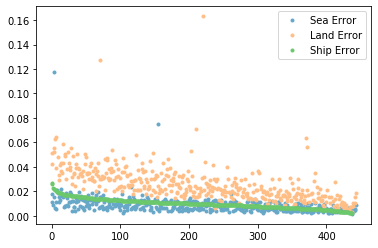

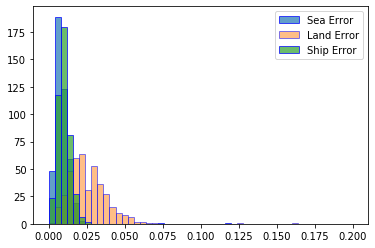

In [30]:
print('Land Error:', count_error['land'].dropna().mean())
print('Ship Error:', count_error['ship'].dropna().mean()*0.5)
print('Sea Error:', count_error['sea'].dropna().mean())
plt.plot( count_error['sea'].values,'r.',label='Sea Error',color=(103/255,167/255,200/255) )
plt.plot( count_error['land'].values,'b.',label='Land Error',color=(255/255,190/255,134/255) )
plt.plot( count_error['ship'].values,'m.',label='Ship Error',color=(107/255,200/255,107/255) )
plt.legend()
plt.savefig('Graphs/SAMMIE-Scatter')

plt.figure()
plt.hist( count_error['sea'],range=[0,0.2], bins=50,edgecolor='b',alpha=0.7,label='Sea Error');
plt.hist(count_error['land'],range=[0,0.2],bins = 50,edgecolor='b',alpha=0.5,label='Land Error');
plt.hist( count_error['ship'],range=[0,0.2], bins=50,edgecolor='b',alpha=0.7,label='Ship Error');
plt.legend()
plt.savefig('Graphs/SAMMIE-Hist')